In [1]:
! pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114248 sha256=9d428c8b76562283cca58b071a750abde5b4207fa163bc19de2a9de51a885e92
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from medmnist import OCTMNIST 

In [4]:
class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = experience
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
def create_model(num_classes, input_shape=(28,28,1)):
    model = Sequential([
        Conv2D(25, (4,4), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(111, (4,4), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(123, (4,4), activation='relu'),
        Flatten(),
        Dense(102, activation='relu'),
        Dropout(0.3619968138672127),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [21]:
import numpy as np

# Generate noisy samples (assuming this function already exists)
def generate_noisy_samples(num_samples, input_shape):
    return np.random.rand(num_samples, *input_shape)

# Define the shape of your input data
input_shape = (28, 28, 1)

# Number of noisy samples to add
num_noisy_samples = 100000  # Adjust this number as needed

# Generate noisy samples
noisy_samples = generate_noisy_samples(num_noisy_samples, input_shape)

# Create labels for the noisy samples (e.g., 50 labeled as 0 and 50 as 1)
noisy_labels_0 = np.zeros(num_noisy_samples // 2)  # First half as class 0
noisy_labels_1 = np.ones(num_noisy_samples // 2)   # Second half as class 1

# Combine the labels
noisy_labels = np.concatenate([noisy_labels_0, noisy_labels_1])

# Shuffle the noisy samples and labels together
shuffled_indices = np.random.permutation(num_noisy_samples)
noisy_samples = noisy_samples[shuffled_indices]
noisy_labels = noisy_labels[shuffled_indices]

y_train_2 = y_train_2.reshape(-1)  # Ensures it's 1D

# Now, add these noisy samples to the original training set
X_train_augmented = np.concatenate([X_train_2, noisy_samples], axis=0)
y_train_augmented = np.concatenate([y_train_2, noisy_labels], axis=0)

# Check shapes of augmented data
print(f"Shape of augmented X_train: {X_train_augmented.shape}")  # Should be (35097, 28, 28, 1)
print(f"Shape of augmented y_train: {y_train_augmented.shape}")  # Should be (35097,)



Shape of augmented X_train: (144997, 28, 28, 1)
Shape of augmented y_train: (144997,)


In [7]:
def extend_output_layer(model, new_num_classes):
    model_layers = [layer for layer in model.layers[:-1]]
    
    new_model = Sequential(model_layers)
    
    new_model.add(Dense(new_num_classes, activation='softmax'))
    
    for i in range(len(new_model.layers)-1):
        new_model.layers[i].set_weights(model.layers[i].get_weights())
    
    new_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    
    return new_model

In [8]:
# download and split
train = OCTMNIST(split='train', download=True)
val = OCTMNIST(split='val', download=True)


100%|██████████| 54938180/54938180 [00:03<00:00, 14005663.85it/s]


Using downloaded and verified file: /root/.medmnist/octmnist.npz


In [9]:
X, y = train.imgs, train.labels
X_val, y_val = val.imgs, val.labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Add channel dimension
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

In [10]:
print("Number of images in training set:", len(X_train))
print("Number of images in validation set:", len(X_val))
print("Number of images in test set:", len(X_test))
print("Total : ",len(X_train)+len(X_val)+len(X_test))

Number of images in training set: 77981
Number of images in validation set: 10832
Number of images in test set: 19496
Total :  108309


In [11]:
def filter_data_by_classes(X, y, classes):
#     print("Getting the dataset")
    if y.ndim > 1:
        y = y.flatten()
    filter_mask = np.isin(y, classes)
    return X[filter_mask], y[filter_mask]

In [12]:
def incremental_learning_separate(model, replay_buffer, batch_size, epochs, train_histories, new_data, X_val, y_val):
    for i in range(len(new_data[0])):
        replay_buffer.push((new_data[0][i], new_data[1][i]))
        
    if len(replay_buffer) >= replay_buffer.capacity:
        print("Warning: Replay buffer is at full capacity!")

    if len(replay_buffer) >= batch_size:
        batch = replay_buffer.sample(batch_size)
        X_replay, y_replay = zip(*batch)
        X_replay = np.array(X_replay)
        y_replay = np.array(y_replay)
        
    if len(replay_buffer) < batch_size:
        print(f"Using smaller replay batch of size {len(replay_buffer)}.")
        batch_size = len(replay_buffer)
        batch = replay_buffer.sample(batch_size)
        X_replay, y_replay = zip(*batch)
        X_replay = np.array(X_replay)
        y_replay = np.array(y_replay)

    else:
        X_replay, y_replay = np.array([]), np.array([])

    if len(X_replay) > 0:
        X_train_combined = np.concatenate((X_replay, new_data[0]), axis=0)
        y_train_combined = np.concatenate((y_replay, new_data[1]), axis=0)
    else:
        X_train_combined = new_data[0]
        y_train_combined = new_data[1]

    indices = np.arange(X_train_combined.shape[0])
    np.random.shuffle(indices)
    X_train_combined = X_train_combined[indices]
    y_train_combined = y_train_combined[indices]

#     print(f"Combined training data shape: {X_train_combined.shape}, {y_train_combined.shape}")

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs} started (new class added)')
        try:
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
            
            class_weights = compute_class_weight(
                class_weight='balanced',
                classes=np.unique(y_train_combined),
                y=y_train_combined
            )
            class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

            
#             history_replay = model.fit(X_train_combined, y_train_combined, batch_size=batch_size,
#                            epochs=epochs, validation_data=(X_val, y_val),
#                            callbacks=[early_stopping],
#                            class_weight=class_weight_dict)
            
#             history_replay = model.fit(X_train_combined, y_train_combined, batch_size=batch_size, 
#                            epochs=epochs, validation_data=(X_val, y_val), 
#                            callbacks=[early_stopping])

            history_replay = model.fit(X_train_combined, y_train_combined, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
#             train_histories.append(history_replay.history)
            return history_replay
        except Exception as e:
            print(f"Error during training: {e}")

In [13]:
def evaluate_model_on_test(model, X_test, y_test, task_num):
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    print(f"\nClassification report for Task {task_num}:")
    print(classification_report(y_test, y_pred, target_names=[f"Class {i}" for i in np.unique(y_test)]))

In [14]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(history):
    plt.figure(figsize=(12, 5))

    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy', color='b', marker='o')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', color='g', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss', color='b', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', color='g', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


In [55]:
batch_size = 32
epochs = 10
replay_buffer_capacity = 1000000
train_histories = []

replay_buffer = ExperienceReplay(capacity=replay_buffer_capacity)

num_classes = 2
model = create_model(num_classes)

In [49]:
def add_noise(X, noise_factor=0.2):
    noise = np.random.normal(loc=0.0, scale=1.0, size=X.shape)
    noisy_X = X + noise_factor * noise
    return np.clip(noisy_X, 0., 1.)

# During training
X_train_noisy = add_noise(X_train_2)

In [50]:
X_train_2, y_train_2 = filter_data_by_classes(X_train, y_train, [0,1])
X_val_2, y_val_2 = filter_data_by_classes(X_val, y_val, [0,1])
X_test_2, y_test_2 = filter_data_by_classes(X_test, y_test, [0,1])
# X_train_2, y_train_2= X_train_augmented,y_train_augmented
X_train_2 = X_train_noisy


Training on 2 classes (0,1)...
Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7639 - loss: 0.5443 - val_accuracy: 0.7681 - val_loss: 0.4700
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7744 - loss: 0.4858 - val_accuracy: 0.8060 - val_loss: 0.4191
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7938 - loss: 0.4547 - val_accuracy: 0.7982 - val_loss: 0.4108
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8104 - loss: 0.4302 - val_accuracy: 0.7961 - val_loss: 0.4182
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8132 - loss: 0.4232 - val_accuracy: 0.7976 - val_loss: 0.4225
Epoch 6/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8237 - loss: 0.3995 - val_accuracy: 0.8295 - val_loss: 0.3591
Epoch 7/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8308 - loss: 0.3824 - val_accuracy: 0.8009 - val_loss: 0.4478
Epoch 8/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - ac

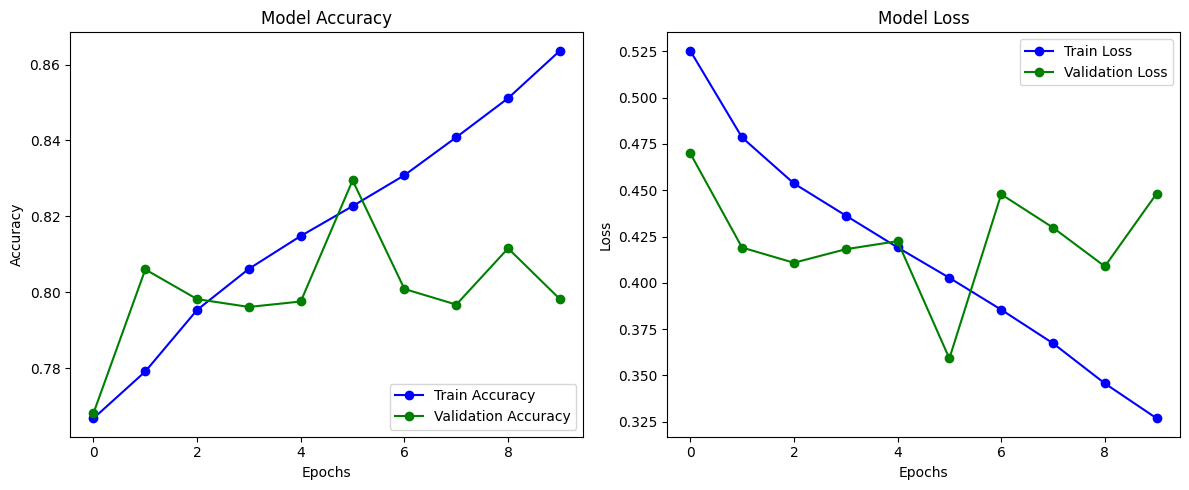

In [51]:
print("Training on 2 classes (0,1)...")
history = model.fit(X_train_2, y_train_2, batch_size=batch_size, epochs=epochs, validation_data=(X_val_2, y_val_2))
# train_histories.append(history_initial.history)
evaluate_model_on_test(model, X_test_2, y_test_2, task_num=1)
plot_accuracy_loss(history.history)

In [71]:
# X_train_only_2, y_train_only_2 = filter_data_by_classes(X_train, y_train, [0,1,2,3])
# X_val_only_2, y_val_only_2 = filter_data_by_classes(X_train, y_train, [0,1,2,3])
# X_test_only_2, y_test_only_2 = filter_data_by_classes(X_train, y_train, [0,1,2,3])

# for i in range(len(X_train_only_2)):
#     replay_buffer.push((X_train_only_2[i], y_train_only_2[i]))
#     replay_buffer.push((X_val_only_2[i], y_val_only_2[i]))
#     replay_buffer.push((X_test_only_2[i], y_test_only_2[i]))

In [72]:
# replay_buffer_capacity = 10000000
# replay_buffer = ExperienceReplay(capacity=replay_buffer_capacity)

In [73]:
# X_train_only_2, y_train_only_2 = filter_data_by_classes(X_train, y_train, [1,2])
# X_val_only_2, y_val_only_2 = filter_data_by_classes(X_train, y_train, [1,2])
# X_test_only_2, y_test_only_2 = filter_data_by_classes(X_train, y_train, [1,2])

# for i in range(len(X_train_only_2)):
#     replay_buffer.push((X_train_only_2[i], y_train_only_2[i]))
#     replay_buffer.push((X_val_only_2[i], y_val_only_2[i]))
#     replay_buffer.push((X_test_only_2[i], y_test_only_2[i]))

In [34]:
X_train_01, y_train_01 = filter_data_by_classes(X_train, y_train, [0,1])

for i in range(len(X_train_01)):
    replay_buffer.push((X_train_01[i], y_train_01[i]))

In [56]:
num_classes = 3  # Introducing the third class
model1 = extend_output_layer(model, num_classes)

X_train_3, y_train_3 = filter_data_by_classes(X_train, y_train, [0,1,2])
X_val_3, y_val_3 = filter_data_by_classes(X_val, y_val, [0,1,2])
X_test_3, y_test_3 = filter_data_by_classes(X_test, y_test, [0,1,2])


Training on new class (2)...
Epoch 1/10 started (new class added)
Epoch 1/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7000 - loss: 0.7264 - val_accuracy: 0.8405 - val_loss: 0.4164
Epoch 2/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8414 - loss: 0.4103 - val_accuracy: 0.8464 - val_loss: 0.3857
Epoch 3/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8625 - loss: 0.3597 - val_accuracy: 0.8823 - val_loss: 0.3111
Epoch 4/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8776 - loss: 0.3165 - val_accuracy: 0.8832 - val_loss: 0.3096
Epoch 5/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8893 - loss: 0.2889 - val_accuracy: 0.8704 - val_loss: 0.3365
Epoch 6/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9002 - loss: 0.2619 - val_accuracy: 0.8886 - val_loss: 0.2962
Epoch 7/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9045 - loss: 0.2461 - val_accuracy: 0.9068 - val_loss: 0.2654
Epoch 8/10
1288/1288 ━

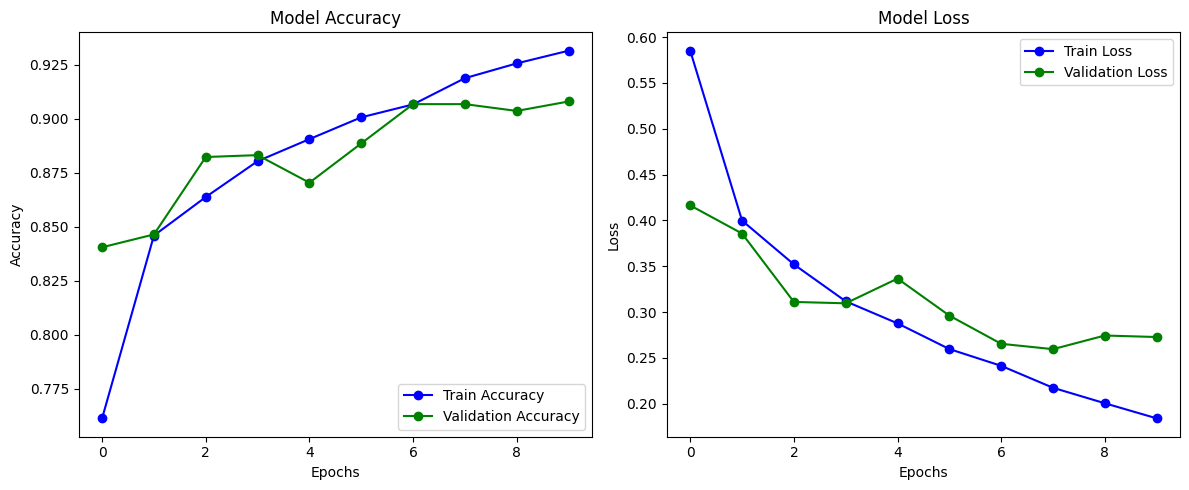

In [57]:
epochs = 10
print("\nTraining on new class (2)...")
model1_history = incremental_learning_separate(model1, replay_buffer, batch_size, epochs, train_histories, (X_train_3, y_train_3), X_val_3, y_val_3)
# train_histories.append(train_histories[-1])
evaluate_model_on_test(model1, X_test_3, y_test_3, task_num=2)
plot_accuracy_loss(model1_history.history)

In [37]:
# def create_model(best_params):
#     model = Sequential([
#         Conv2D(25, (4,4), activation='relu', input_shape=(X_train.shape[1:])),
#         MaxPooling2D((2, 2)),
#         Conv2D(111, (4,4), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Conv2D(123, (4,4), activation='relu'),
#         Flatten(),
#         Dense(102, activation='relu'),
#         Dropout(0.3619968138672127),
#         Dense(4, activation='softmax') 
#     ])

#     model.compile(optimizer=Adam(learning_rate=0.0007008969316805274),
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
# #     print('Model has been defined with the best parameters...')
#     return model

In [38]:
# best_params = {
#     'conv_filters_1': 25,
#     'conv_filters_2': 111,
#     'conv_filters_3': 123,
#     'kernel_size': 4,
#     'dense_units': 102,
#     'learning_rate': 0.0007008969316805274,
#     'dropout_rate': 0.3619968138672127
#     }
# model = create_model(best_params)

In [39]:
# X_train_only_2, y_train_only_2 = filter_data_by_classes(X_train, y_train, [2])
# X_val_only_2, y_val_only_2 = filter_data_by_classes(X_train, y_train, [2])
# X_test_only_2, y_test_only_2 = filter_data_by_classes(X_train, y_train, [2])

# for i in range(len(X_train_only_2)):
#     replay_buffer.push((X_train_only_2[i], y_train_only_2[i]))
#     replay_buffer.push((X_val_only_2[i], y_val_only_2[i]))
#     replay_buffer.push((X_test_only_2[i], y_test_only_2[i]))

In [40]:
# replay_buffer_capacity = 100000
# replay_buffer = ExperienceReplay(capacity=replay_buffer_capacity)

In [41]:
def train_final_model(model,replay_buffer,batch_size,epochs,X_train,y_train,X_val,y_val):
    train_histories = []

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs} started')

        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
        train_histories.append(history.history)

        for i in range(len(X_train)):
            replay_buffer.push((X_train[i], y_train[i]))

        if len(replay_buffer) > batch_size:
            batch = replay_buffer.sample(batch_size)
            X_replay, y_replay = zip(*batch)
            X_replay = np.array(X_replay)
            y_replay = np.array(y_replay)

            history_replay = model.fit(X_replay, y_replay, batch_size=batch_size, epochs=1)
            train_histories.append(history_replay.history)
            return history

In [61]:
X_train_only_2, y_train_only_2 = filter_data_by_classes(X_train, y_train, [0,1,2,3])

for i in range(len(X_train_only_2)):
    replay_buffer.push((X_train_only_2[i], y_train_only_2[i]))

In [62]:
num_classes = 4  # Introducing the fourth class
model2 = extend_output_layer(model1, num_classes)

X_train_4, y_train_4 = filter_data_by_classes(X_train, y_train, [0,1,2,3])
X_val_4, y_val_4 = filter_data_by_classes(X_val, y_val, [0,1,2,3])
X_test_4, y_test_4 = filter_data_by_classes(X_test, y_test, [0,1,2,3])


Training on new class (3)...
Epoch 1/10 started
Epoch 1/10
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9073 - loss: 0.2759 - val_accuracy: 0.8995 - val_loss: 0.3535
Epoch 2/10
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9479 - loss: 0.1552 - val_accuracy: 0.8988 - val_loss: 0.3595
Epoch 3/10
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9522 - loss: 0.1387 - val_accuracy: 0.8998 - val_loss: 0.3542
Epoch 4/10
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9557 - loss: 0.1310 - val_accuracy: 0.9057 - val_loss: 0.3642
Epoch 5/10
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9569 - loss: 0.1249 - val_accuracy: 0.9010 - val_loss: 0.3906
Epoch 6/10
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9593 - loss: 0.1184 - val_accuracy: 0.8942 - val_loss: 0.4319
Epoch 7/10
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9615 - loss: 0.1110 - val_accuracy: 0.9010 - val_loss: 0.4226
Epoch 8/10
2437/2437 ━━━━━━━━━━━━━━━━━━━

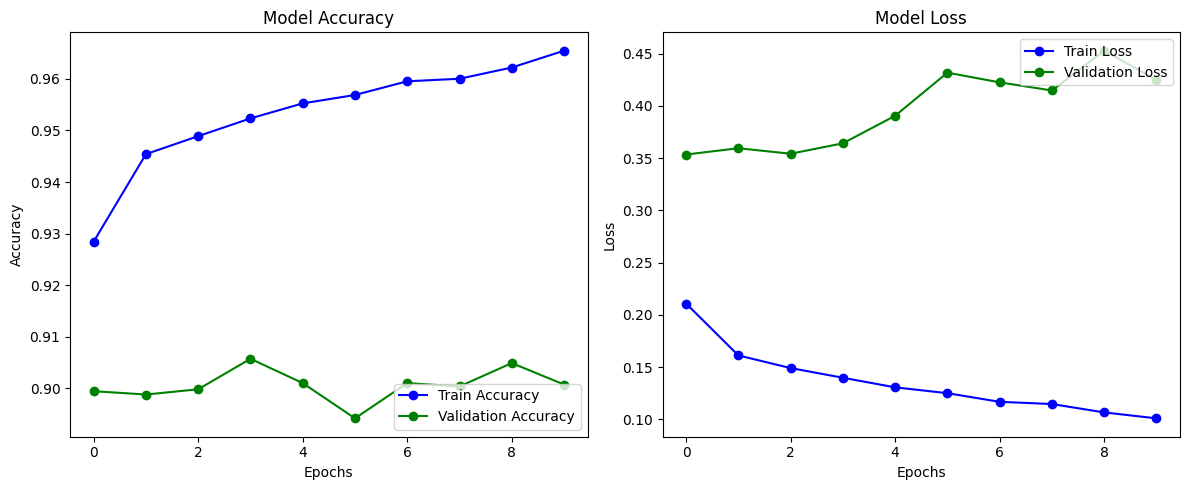

In [63]:
print("\nTraining on new class (3)...")
# history = incremental_learning_separate(model, replay_buffer, batch_size, epochs, train_histories, (X_train_2, y_train_2), X_val_2, y_val_2)
# train_histories.append(train_histories[-1])  
model2_history = train_final_model(model2,replay_buffer,batch_size,epochs,X_train_4,y_train_4,X_val_4,y_val_4)
evaluate_model_on_test(model2, X_test_4, y_test_4, task_num=3)
plot_accuracy_loss(model2_history.history)

610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


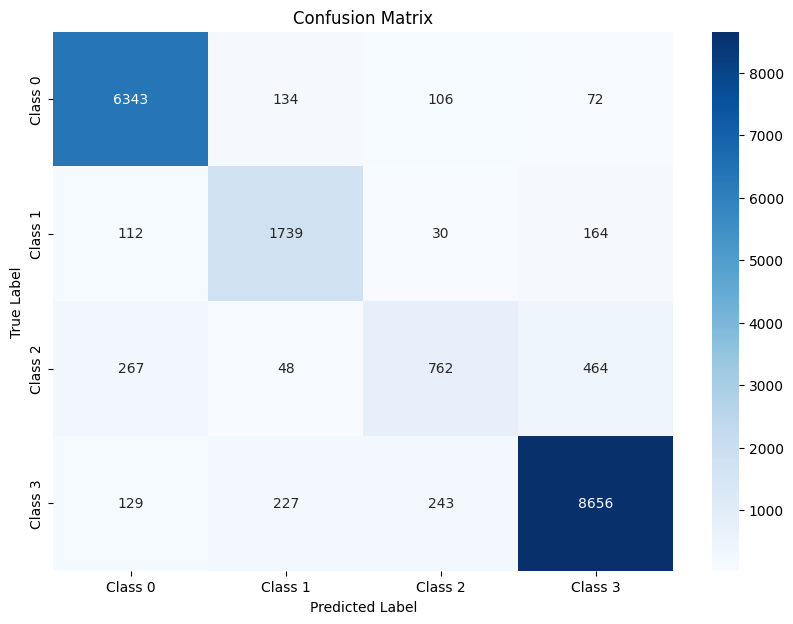

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(model2.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

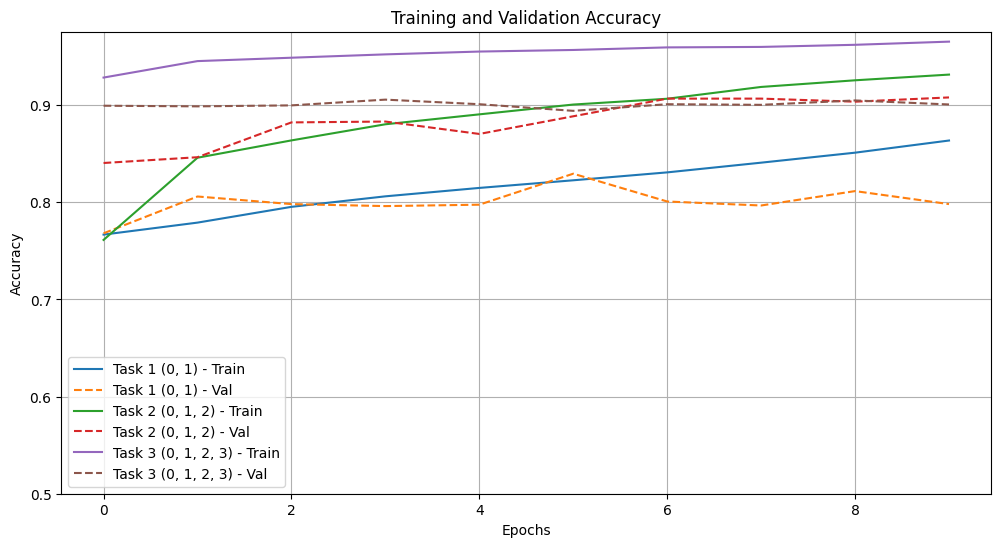

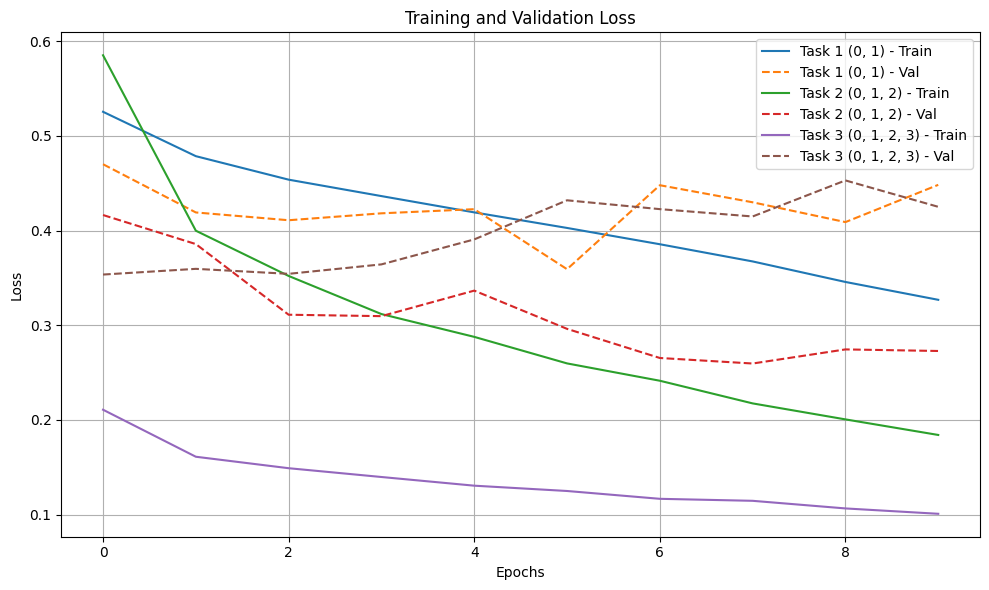

In [64]:
import matplotlib.pyplot as plt
import numpy as np

def plot_task_accuracies(histories, task_labels):
    plt.figure(figsize=(12, 6))

    for i, history in enumerate(histories):
        # Access accuracy from the History object
        plt.plot(history.history['accuracy'], label=f'Task {task_labels[i]} - Train')
        plt.plot(history.history['val_accuracy'], label=f'Task {task_labels[i]} - Val', linestyle='--')
    
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.yticks(np.arange(0.5, 1, 0.1))
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_task_losses(histories, task_labels):
    plt.figure(figsize=(10, 6))
    
    for i, history in enumerate(histories):
        # Access loss from the History object
        plt.plot(history.history['loss'], label=f'Task {task_labels[i]} - Train')
        plt.plot(history.history['val_loss'], label=f'Task {task_labels[i]} - Val', linestyle='--')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Collect the histories for each task
task_histories = [history, model1_history, model2_history]
task_labels = ['1 (0, 1)', '2 (0, 1, 2)', '3 (0, 1, 2, 3)']

# Call the plotting function
plot_task_accuracies(task_histories, task_labels)
plot_task_losses(task_histories, task_labels)


<h1> Experiment
    

In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from medmnist import OCTMNIST 

# Define your Experience Replay class
class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = experience
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Define your CNN model
def create_model(num_classes, input_shape=(28,28,1)):
    model = Sequential([
        Conv2D(25, (4,4), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(111, (4,4), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(123, (4,4), activation='relu'),
        Flatten(),
        Dense(102, activation='relu'),
        Dropout(0.36),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Function to extend the model when adding new classes
def extend_output_layer(model, new_num_classes):
    # Get all layers except the output layer
    model_layers = [layer for layer in model.layers[:-1]]
    
    # Rebuild the model with the same layers but a new output layer
    new_model = Sequential(model_layers)
    
    # Add the new output layer
    new_model.add(Dense(new_num_classes, activation='softmax'))
    
    # Transfer weights except for the final layer
    for i in range(len(new_model.layers)-1):
        new_model.layers[i].set_weights(model.layers[i].get_weights())
    
    # Recompile the model with the same optimizer and loss
    new_model.compile(optimizer=Adam(learning_rate=0.0001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    
    return new_model




# Load and preprocess data
train = OCTMNIST(split='train', download=True)
val = OCTMNIST(split='val', download=True)

# Extract data and labels
X, y = train.imgs, train.labels
X_val, y_val = val.imgs, val.labels

# Print dataset sizes
print("Train dataset:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

print("\nValidation dataset:")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Add channel dimension
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

# Print sizes after preprocessing
print("\nPost-processing:")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

# Filter data by classes
def filter_data_by_classes(X, y, classes):
    # Ensure y is a 1D array
    if y.ndim > 1:
        y = y.flatten()

    # Print shapes for debugging
    print(f"Filtering classes {classes} from data...")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")

    # Create boolean mask for filtering classes
    filter_mask = np.isin(y, classes)
    print(f"Filter mask shape: {filter_mask.shape}")
    print(f"Unique labels in filtered data: {np.unique(y[filter_mask])}")

    # Apply boolean mask to filter data
    return X[filter_mask], y[filter_mask]

# Incremental Learning with Separate Training for New Classes
def incremental_learning_separate(model, replay_buffer, batch_size, epochs, train_histories, new_data, X_val, y_val):
    # Add new data to replay buffer
    for i in range(len(new_data[0])):
        replay_buffer.push((new_data[0][i], new_data[1][i]))
        
    # Buffer capacity could be dynamically adjusted if needed
    if len(replay_buffer) >= replay_buffer.capacity:
        print("Warning: Replay buffer is at full capacity!")

    # If replay buffer has enough samples, sample a batch
    if len(replay_buffer) >= batch_size:
        batch = replay_buffer.sample(batch_size)
        X_replay, y_replay = zip(*batch)
        X_replay = np.array(X_replay)
        y_replay = np.array(y_replay)
        
    if len(replay_buffer) < batch_size:
        print(f"Using smaller replay batch of size {len(replay_buffer)}.")
        batch_size = len(replay_buffer)
        batch = replay_buffer.sample(batch_size)
        X_replay, y_replay = zip(*batch)
        X_replay = np.array(X_replay)
        y_replay = np.array(y_replay)

    else:
        X_replay, y_replay = np.array([]), np.array([])

    # Combine with new data
    if len(X_replay) > 0:
        X_train_combined = np.concatenate((X_replay, new_data[0]), axis=0)
        y_train_combined = np.concatenate((y_replay, new_data[1]), axis=0)
    else:
        X_train_combined = new_data[0]
        y_train_combined = new_data[1]

    # Shuffle combined data
    indices = np.arange(X_train_combined.shape[0])
    np.random.shuffle(indices)
    X_train_combined = X_train_combined[indices]
    y_train_combined = y_train_combined[indices]

    # Print combined data shape
    print(f"Combined training data shape: {X_train_combined.shape}, {y_train_combined.shape}")

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs} started (new class added)')
        try:
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
            
            class_weights = compute_class_weight(
                class_weight='balanced',
                classes=np.unique(y_train_combined),
                y=y_train_combined
            )
            class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

            
            history_replay = model.fit(X_train_combined, y_train_combined, batch_size=batch_size,
                           epochs=epochs, validation_data=(X_val, y_val),
                           callbacks=[early_stopping],
                           class_weight=class_weight_dict)
            
#             history_replay = model.fit(X_train_combined, y_train_combined, batch_size=batch_size, 
#                            epochs=epochs, validation_data=(X_val, y_val), 
#                            callbacks=[early_stopping])

#             history_replay = model.fit(X_train_combined, y_train_combined, batch_size=batch_size, epochs=1, validation_data=(X_val, y_val))
            train_histories.append(history_replay.history)
        except Exception as e:
            print(f"Error during training: {e}")
    
def evaluate_model_on_test(model, X_test, y_test, task_num):
    # Predict classes for the test set
    y_pred = np.argmax(model.predict(X_test), axis=-1)

    # Print classification report for the current task
    print(f"\nClassification report for Task {task_num}:")
    print(classification_report(y_test, y_pred, target_names=[f"Class {i}" for i in np.unique(y_test)]))
    
    

# Parameters
batch_size = 32
epochs = 10
replay_buffer_capacity = 100000
train_histories = []

# Initialize replay buffer
replay_buffer = ExperienceReplay(capacity=replay_buffer_capacity)

# Create initial model
num_classes = 2
model = create_model(num_classes)

# Step 1: Train on first 2 classes (0, 1)
print("Training on 2 classes (0, 1)...")
X_train_2, y_train_2 = filter_data_by_classes(X_train, y_train, [0,1])
X_val_2, y_val_2 = filter_data_by_classes(X_val, y_val, [0,1])
X_test_2, y_test_2 = filter_data_by_classes(X_test, y_test, [0,1])



# Print sizes before training
print("\nTraining data (0, 1):")
print(f"X_train_2 shape: {X_train_2.shape}")
print(f"y_train_2 shape: {y_train_2.shape}")
print(f"X_val_2 shape: {X_val_2.shape}")
print(f"y_val_2 shape: {y_val_2.shape}")

# Check unique labels
print("Unique labels for 0 and 1 training :", np.unique(y_train_2))
# Validate that only classes 0, 1, and 2 are in the validation set during the incremental step for class 2
print(f"Unique labels in validation for class 0 and 1 training: {np.unique(y_val_2)}")


# Train on the initial classes
history_initial = model.fit(X_train_2, y_train_2, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
train_histories.append(history_initial.history)

evaluate_model_on_test(model, X_test_2, y_test_2, task_num=1)


# Add initial data to replay buffer
for i in range(len(X_train_2)):
    replay_buffer.push((X_train_2[i], y_train_2[i]))

    
# Step 2: Introduce third class (2)
print("\nTraining on new class (2)...")
# After training on the first 2 classes (0, 1):
num_classes = 3  # Introducing the third class
model = extend_output_layer(model, num_classes)

X_train_2, y_train_2 = filter_data_by_classes(X_train, y_train, [0,1,2])
X_val_2, y_val_2 = filter_data_by_classes(X_val, y_val, [0,1,2])
X_test_2, y_test_2 = filter_data_by_classes(X_test, y_test, [0,1,2])


# Print sizes before incremental training
print("\nNew class (2) data:")
print(f"X_train_2 shape: {X_train_2.shape}")
print(f"y_train_2 shape: {y_train_2.shape}")
print("Unique labels in adding class label 2:", np.unique(y_train_2))
# Validate that only classes 0, 1, and 2 are in the validation set during the incremental step for class 2
print(f"Unique labels in validation for class 0,1 and 2 training: {np.unique(y_val_2)}")



# Perform incremental training
incremental_learning_separate(model, replay_buffer, batch_size, epochs, train_histories, (X_train_2, y_train_2), X_val_2, y_val_2)

evaluate_model_on_test(model, X_test_2, y_test_2, task_num=2)

# Step 3: Finally introduce the 4th class (3)
print("\nTraining on new class (3)...")
# After training on the third class, extend the model for the fourth class
num_classes = 4  # Introducing the fourth class
model = extend_output_layer(model, num_classes)

X_train_2, y_train_2 = filter_data_by_classes(X_train, y_train, [0,1,2,3])
X_val_2, y_val_2 = filter_data_by_classes(X_val, y_val, [0,1,2,3])
X_test_2, y_test_2 = filter_data_by_classes(X_test, y_test, [0,1,2,3])


# Print sizes before incremental training
print("\nNew class (3) data:")
print(f"X_train_2 shape: {X_train_2.shape}")
print(f"y_train_2 shape: {y_train_2.shape}")
print("Unique labels in adding class label 3 :", np.unique(y_train_2))
# Validate that only classes 0, 1, and 2 are in the validation set during the incremental step for class 2
print(f"Unique labels in validation for all classes training: {np.unique(y_val_2)}")



# Perform incremental training
incremental_learning_separate(model, replay_buffer, batch_size, epochs, train_histories, (X_train_2, y_train_2), X_val_2, y_val_2)

evaluate_model_on_test(model, X_test_2, y_test_2, task_num=3)
